# Step1 Data processing

In [1]:
import pybedtools
import pyBigWig
import os
import numpy as np
import pandas as pd

In [2]:
#Create a function to filter valid HMR regions
def filter_valid_intervals(intervals, bw):
    valid_intervals = []
    chroms = bw.chroms()
    for interval in intervals:
        chrom, start, end = interval[0], int(interval[1]), int(interval[2])

        # Check if the chromosome exists in the bigwig file
        if chrom not in chroms:
            continue

        chrom_length = chroms[chrom]
        start = max(0, start)
        end = min(chrom_length, end)
        if start < end:
            valid_intervals.append((chrom, start, end))
    return valid_intervals

In [3]:
#input files
HMR_file = "banana/data_hic/Input1_Boundary_microC/Boundary_minus_1000_resolution10000.bed"
TF_folder = "banana/data_hic/Input3_new/"
bigwig_file1 = "banana/data_hic/Input2_CTCT_Boundary/ChIPseq_GSE124667_MCF7_CTCF_NT_NT_rep0.single-bowtie2-hg38-raw-GR.100.bw"
bigwig_file2 = "banana/data_hic/Input2-Cohesin-ForBoundary/Rad21_ENCSR000BTQ_rep1.mpbl.100.bw"
h1d_file = "banana/data_hic/H1D_Micro_10000/minus_10000_CI.bedGraph"

In [4]:
#convert TF files to pybedtools.BedTool format,
tf_files = [os.path.join(TF_folder, f) for f in os.listdir(TF_folder) if f.endswith('.bed')]
bed_files = [pybedtools.BedTool(f) for f in tf_files]

In [5]:
# Filter HMR intervals
HMR = pybedtools.BedTool(HMR_file)
bw = pyBigWig.open(bigwig_file1)
filtered_HMR = filter_valid_intervals(HMR, bw)
filtered_HMR

[('chr1', 2820000, 2821000),
 ('chr1', 2821000, 2822000),
 ('chr1', 2822000, 2823000),
 ('chr1', 2823000, 2824000),
 ('chr1', 2824000, 2825000),
 ('chr1', 2825000, 2826000),
 ('chr1', 2826000, 2827000),
 ('chr1', 2827000, 2828000),
 ('chr1', 2828000, 2829000),
 ('chr1', 2829000, 2830000),
 ('chr1', 3420000, 3421000),
 ('chr1', 3421000, 3422000),
 ('chr1', 3422000, 3423000),
 ('chr1', 3423000, 3424000),
 ('chr1', 3424000, 3425000),
 ('chr1', 3425000, 3426000),
 ('chr1', 3426000, 3427000),
 ('chr1', 3427000, 3428000),
 ('chr1', 3428000, 3429000),
 ('chr1', 3429000, 3430000),
 ('chr1', 8560000, 8561000),
 ('chr1', 8561000, 8562000),
 ('chr1', 8562000, 8563000),
 ('chr1', 8563000, 8564000),
 ('chr1', 8564000, 8565000),
 ('chr1', 8565000, 8566000),
 ('chr1', 8566000, 8567000),
 ('chr1', 8567000, 8568000),
 ('chr1', 8568000, 8569000),
 ('chr1', 8569000, 8570000),
 ('chr1', 8690000, 8691000),
 ('chr1', 8691000, 8692000),
 ('chr1', 8692000, 8693000),
 ('chr1', 8693000, 8694000),
 ('chr1', 8694

In [6]:
# Convert filtered_HMR list to BedTool object
filtered_HMR_bedtool = pybedtools.BedTool(filtered_HMR)

In [7]:
# Calculate overlap_matrix
overlap_matrix = []
for tf in bed_files:
    overlaps = filtered_HMR_bedtool.intersect(tf, c=True)
    overlap_counts = [int(interval[-1]) for interval in overlaps]
    overlap_matrix.append(overlap_counts)

In [8]:
overlap_matrix = np.array(overlap_matrix).T
overlap_matrix = (overlap_matrix - overlap_matrix.min()) / (overlap_matrix.max() - overlap_matrix.min())

In [9]:
# Calculate response_vector
def calculate_avg_signal(bigwig_file, filtered_HMR):
    bw = pyBigWig.open(bigwig_file)
    response_vector = []

    for interval in filtered_HMR:
        chrom, start, end = interval

        # Make sure start and end positions are within chromosome bounds
        chrom_length = bw.chroms()[chrom]
        start = max(0, start)
        end = min(chrom_length, end)

        if start < end:
            avg_signal = bw.stats(chrom, start, end, type='mean')[0]
            if avg_signal is None:
                avg_signal = 0
        else:
            avg_signal = 0

        response_vector.append(avg_signal)

    bw.close()

    return response_vector

# Calculate response_vector
response_vector1 = calculate_avg_signal(bigwig_file1, filtered_HMR)
response_vector2 = calculate_avg_signal(bigwig_file2, filtered_HMR)

In [10]:
#log transformation
response_vector1 = np.array(response_vector1) + 1
response_vector1 = np.log(response_vector1)
response_vector1 = (response_vector1 - response_vector1.min()) / (response_vector1.max() - response_vector1.min())

response_vector2 = np.array(response_vector2) + 1
response_vector2 = np.log(response_vector2)
response_vector2 = (response_vector2 - response_vector2.min()) / (response_vector2.max() - response_vector2.min())


In [11]:
def calculate_avg_signal_h1d(h1d_file, filtered_HMR):
    # Read BED intervals from the H1D file and store them in a list
    bed_intervals = [line.strip().split() for line in open(h1d_file)]
    bed_dict = {}  # Initialize a dictionary to store intervals by chromosome

    # Process each BED interval
    for bed_interval in bed_intervals:
        chrom, start, end = bed_interval[0], int(bed_interval[1]), int(bed_interval[2])
        value = float(bed_interval[3]) if len(bed_interval) == 4 else 0.0  # Extract signal value or set to 0.0
        if chrom not in bed_dict:
            bed_dict[chrom] = []
        bed_dict[chrom].append((start, end, value))

    response_vector = []  # Initialize the response vector to store average signals for filtered HMR intervals

    # Calculate the average signal for each interval in filtered_HMR
    for interval in filtered_HMR:
        chrom, start, end = interval
        if chrom not in bed_dict:
            response_vector.append(0)  # Append 0 if chromosome is not in bed_dict
            continue

        signals = []  # List to store signal values for overlapping intervals
        weights = []  # List to store lengths of overlapping intervals

        # Check for overlaps and calculate weighted average signal
        for bed_start, bed_end, value in bed_dict[chrom]:
            if bed_start < end and bed_end > start:  # Check if intervals overlap
                overlap_start = max(start, bed_start)
                overlap_end = min(end, bed_end)
                overlap_length = overlap_end - overlap_start
                weights.append(overlap_length)
                signals.append(value)

        # Calculate the weighted average signal based on overlaps
        if len(signals) == 1:
            response_vector.append(signals[0])
        elif len(signals) > 1:
            weighted_avg_signal = sum(signal * weight for signal, weight in zip(signals, weights)) / sum(weights)
            response_vector.append(weighted_avg_signal)
        else:
            response_vector.append(0)  # Append 0 if there are no overlaps

    return response_vector

# Calculate the response vector for H1D data
response_vector_h1d = calculate_avg_signal_h1d(h1d_file, filtered_HMR)

# Ensure the response_vector_h1d is a NumPy array for further processing
response_vector_h1d = np.array(response_vector_h1d)

# Normalize the response_vector_h1d by applying log transformation and scaling to [0, 1]
response_vector_h1d = np.log(response_vector_h1d + 1)  # Add 1 to avoid log(0)
response_vector_h1d = (response_vector_h1d - response_vector_h1d.min()) / (response_vector_h1d.max() - response_vector_h1d.min())


In [12]:
# Filter out only string-type file names from the list of transcription factor files
tf_files_filtered = [name for name in tf_files if isinstance(name, str)]

# Simplify the file names by removing the path prefix and the '.bed' extension
tf_files_simplified = [name.replace('banana/data_hic/Input3_new/', '').replace('.bed', '') for name in tf_files_filtered]

# Display the simplified transcription factor file names
tf_files_simplified


['NRSF_v042211',
 'HDAC2_ENCSR000BTP_rep1_peaks',
 'Rad21_v042211',
 'MED12_veh_GSE101559_peaks',
 'GABP_v042211',
 'YAP_veh_GSE125594_peaks',
 'CBP_Ctrl_peaks',
 'RBP2_E2_rep12_GSE28337_peaks',
 'ESR1_ENCSR463GOT_rep1_peaks',
 'RIP140_veh_rep12_E-MTAB-2576_peaks',
 'NFRKB_ENCSR248IMH_rep2_peaks',
 'TAF1_v042211',
 'AFF4_Ctrl_peaks',
 'FOXA1_ENCSR126YEB_rep2_peaks',
 'MCF7_ER_treat_peaks',
 'Mau2_E2_peaks',
 'BRD3_E2_rep12_GSE109571_peaks',
 'Pol2_E2_45min_peaks',
 'c-Myc_veh_GSE33213_peaks',
 'SUZ12_ENCSR757EMK_rep1_peaks',
 'MCF7_STAG1_CTCFkd_treat_peaks',
 'MCF7_STAG1_treat_rep1_peaks',
 'TCF12_v042211',
 'MCF7_Rad21_treat_rep1_peaks',
 'MCF7_ER_vehicle_peaks',
 'EP300_ENCSR000BTR_rep2_peaks',
 'AP2g_E2_GSE60270_peaks',
 'cJun_veh_GSE102410_peaks',
 'RBP2_veh_rep12_GSE28337_peaks',
 'MEN1_veh_GSE85317_peaks',
 'CEBPB_SC-150_v042211',
 'ER_E2_peaks',
 'CTCF_E2_peaks',
 'BRD4_E2_rep123_GSE55921_peaks',
 'EP300_ENCSR000BTR_rep1_peaks',
 'BRD4_veh_rep123_GSE55921_peaks',
 'PML_SC-71910_

# Step2 Features engineering

In [13]:
import numpy as np
from scipy.spatial.distance import cosine, euclidean  # euclidean import not used in the snippet
from scipy.stats import pearsonr  # pearsonr import not used in the snippet
import pandas as pd

# Ensure overlap_matrix is a NumPy array
# Convert it to a NumPy array if it's not already one
# overlap_matrix = np.array(overlap_matrix)

num_columns = overlap_matrix.shape[1]  # Get the number of columns in the overlap matrix

# Initialize a list to store the results
results = []

# Loop through each pair of columns to calculate metrics and store the results
for i in range(num_columns):
    for j in range(i+1, num_columns):  # Ensure we only compare each pair once
        col_i = overlap_matrix[:, i]  # Extract the ith column
        col_j = overlap_matrix[:, j]  # Extract the jth column

        # Calculate various metrics
        cosine_sim = 1 - cosine(col_i, col_j)  # Calculate cosine similarity between the two columns

        # Append the results to the list
        results.append({
            'Factor_1': tf_files_simplified[i],  # Name of the first factor in the pair
            'Factor_2': tf_files_simplified[j],  # Name of the second factor in the pair
            'Cosine_Similarity': cosine_sim,  # Cosine similarity value for the pair
        })

# Create a DataFrame from the results list
df_A = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_A.to_csv('comparison_results.csv', index=False)

# Display the DataFrame
print(df_A)


/home/zhou/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


                          Factor_1                      Factor_2  \
0                     NRSF_v042211  HDAC2_ENCSR000BTP_rep1_peaks   
1                     NRSF_v042211                 Rad21_v042211   
2                     NRSF_v042211     MED12_veh_GSE101559_peaks   
3                     NRSF_v042211                  GABP_v042211   
4                     NRSF_v042211       YAP_veh_GSE125594_peaks   
...                            ...                           ...   
9175       c-Myc_E2_GSE33213_peaks  Rad21_ENCSR703TNG_rep1_peaks   
9176       c-Myc_E2_GSE33213_peaks       AP2g_veh_GSE60270_peaks   
9177   CTCF_ENCSR000DMR_rep1_peaks  Rad21_ENCSR703TNG_rep1_peaks   
9178   CTCF_ENCSR000DMR_rep1_peaks       AP2g_veh_GSE60270_peaks   
9179  Rad21_ENCSR703TNG_rep1_peaks       AP2g_veh_GSE60270_peaks   

      Cosine_Similarity  
0              0.211143  
1              0.095756  
2              0.022774  
3              0.203137  
4              0.159332  
...                 ...  
9

In [14]:
df_A = df_A.dropna()
df_A

Factor_1                      Factor_2  \
0                     NRSF_v042211  HDAC2_ENCSR000BTP_rep1_peaks   
1                     NRSF_v042211                 Rad21_v042211   
2                     NRSF_v042211     MED12_veh_GSE101559_peaks   
3                     NRSF_v042211                  GABP_v042211   
4                     NRSF_v042211       YAP_veh_GSE125594_peaks   
...                            ...                           ...   
9175       c-Myc_E2_GSE33213_peaks  Rad21_ENCSR703TNG_rep1_peaks   
9176       c-Myc_E2_GSE33213_peaks       AP2g_veh_GSE60270_peaks   
9177   CTCF_ENCSR000DMR_rep1_peaks  Rad21_ENCSR703TNG_rep1_peaks   
9178   CTCF_ENCSR000DMR_rep1_peaks       AP2g_veh_GSE60270_peaks   
9179  Rad21_ENCSR703TNG_rep1_peaks       AP2g_veh_GSE60270_peaks   

      Cosine_Similarity  
0              0.211143  
1              0.095756  
2              0.022774  
3              0.203137  
4              0.159332  
...                 ...  
9175           0.206562  
9176           0.264205  
9177           0.786245  
9178           0.123872  
9179           0.176719  

[8911 rows x 3 columns]

In [15]:
import numpy as np
from scipy.spatial.distance import cosine, cityblock
import pandas as pd

# Assume overlap_matrix is your matrix and tf_files_simplified is a list of factor names.
# Also, assume there are multiple response vectors defined as follows:
# response_vector1 = [...], response_vector2 = [...], response_vector_h1d = [...]

# Define a dictionary mapping each signal vector to its corresponding response vector
response_vectors = {
    'signal_vector1': response_vector1,
    'signal_vector2': response_vector2,
    'h1d_vector': response_vector_h1d
}

# Get the number of columns in the overlap matrix
num_columns = overlap_matrix.shape[1]
# Ensure the list of factor names matches the number of columns in the overlap matrix
factor_names = tf_files_simplified  

# Initialize a DataFrame with the factor names
df_B = pd.DataFrame({'Factor': factor_names})

# Calculate cosine similarity and Manhattan distance between each response vector and each column in the overlap matrix
for column_name, response_vector in response_vectors.items():
    cosine_similarities = []  # List to store cosine similarities
    manhattan_distances = []  # List to store Manhattan distances
    for i in range(overlap_matrix.shape[1]):
        factor_vector = overlap_matrix[:, i]  # Get the i-th column from the overlap matrix
        # Calculate cosine similarity and append to the list
        cosine_sim = 1 - cosine(factor_vector, response_vector)
        cosine_similarities.append(cosine_sim)
        
        # Calculate Manhattan distance and append to the list
        manh_dist = cityblock(factor_vector, response_vector)
        manhattan_distances.append(manh_dist)
    
    # Normalize Manhattan distances to be between 0 and 1
    max_manh_dist = max(manhattan_distances)  # Find the maximum Manhattan distance
    min_manh_dist = min(manhattan_distances)  # Find the minimum Manhattan distance
    normalized_manhattan_distances = [1 - (manh_dist - min_manh_dist) / (max_manh_dist - min_manh_dist) if max_manh_dist != min_manh_dist else 0 for manh_dist in manhattan_distances]
    
    # Add the cosine similarities and normalized Manhattan distances as new columns in df_B
    df_B[column_name + '_cosine'] = cosine_similarities
    df_B[column_name + '_manhattan'] = normalized_manhattan_distances

# Display the DataFrame with calculated metrics
print(df_B)


                             Factor  signal_vector1_cosine  \
0                      NRSF_v042211               0.111613   
1      HDAC2_ENCSR000BTP_rep1_peaks               0.178371   
2                     Rad21_v042211               0.402793   
3         MED12_veh_GSE101559_peaks               0.009606   
4                      GABP_v042211               0.144436   
..                              ...                    ...   
131  ZNF143_E2_rep12_GSE76460_peaks               0.273830   
132         c-Myc_E2_GSE33213_peaks               0.202478   
133     CTCF_ENCSR000DMR_rep1_peaks               0.406610   
134    Rad21_ENCSR703TNG_rep1_peaks               0.398795   
135         AP2g_veh_GSE60270_peaks               0.100685   

     signal_vector1_manhattan  signal_vector2_cosine  \
0                    0.056709               0.127978   
1                    0.141525               0.233728   
2                    0.530092               0.542391   
3                    0.000531  

/home/zhou/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [16]:
df_B

Factor  signal_vector1_cosine  \
0                      NRSF_v042211               0.111613   
1      HDAC2_ENCSR000BTP_rep1_peaks               0.178371   
2                     Rad21_v042211               0.402793   
3         MED12_veh_GSE101559_peaks               0.009606   
4                      GABP_v042211               0.144436   
..                              ...                    ...   
131  ZNF143_E2_rep12_GSE76460_peaks               0.273830   
132         c-Myc_E2_GSE33213_peaks               0.202478   
133     CTCF_ENCSR000DMR_rep1_peaks               0.406610   
134    Rad21_ENCSR703TNG_rep1_peaks               0.398795   
135         AP2g_veh_GSE60270_peaks               0.100685   

     signal_vector1_manhattan  signal_vector2_cosine  \
0                    0.056709               0.127978   
1                    0.141525               0.233728   
2                    0.530092               0.542391   
3                    0.000531               0.010369   
4                    0.084059               0.184133   
..                        ...                    ...   
131                  0.351074               0.340944   
132                  0.143097               0.233666   
133                  0.534649               0.537091   
134                  0.494958               0.542954   
135                  0.035075               0.131379   

     signal_vector2_manhattan  h1d_vector_cosine  h1d_vector_manhattan  
0                    0.056571           0.083777              0.045697  
1                    0.160339           0.120922              0.119799  
2                    0.569071           0.259127              0.413637  
3                    0.000570           0.007424              0.000412  
4                    0.091001           0.102618              0.066898  
..                        ...                ...                   ...  
131                  0.384416           0.198505              0.295485  
132                  0.157707           0.123198              0.119365  
133                  0.571346           0.258832              0.415387  
134                  0.536583           0.243800              0.389142  
135                  0.038351           0.063592              0.028097  

[136 rows x 7 columns]

In [17]:
df_B = df_B.dropna()
# If you want to display all rows of the dataframe, you can set the display.max_rows option in pandas to None
pd.set_option('display.max_rows', None)

# Now when you print df_B, it should display all the rows.
df_B


Factor  signal_vector1_cosine  \
0                          NRSF_v042211               0.111613   
1          HDAC2_ENCSR000BTP_rep1_peaks               0.178371   
2                         Rad21_v042211               0.402793   
3             MED12_veh_GSE101559_peaks               0.009606   
4                          GABP_v042211               0.144436   
5               YAP_veh_GSE125594_peaks               0.150756   
6                        CBP_Ctrl_peaks               0.083518   
7          RBP2_E2_rep12_GSE28337_peaks               0.090048   
8           ESR1_ENCSR463GOT_rep1_peaks               0.124561   
9    RIP140_veh_rep12_E-MTAB-2576_peaks               0.205658   
11                         TAF1_v042211               0.094286   
12                      AFF4_Ctrl_peaks               0.114152   
13         FOXA1_ENCSR126YEB_rep2_peaks               0.160490   
14                  MCF7_ER_treat_peaks               0.211862   
15                        Mau2_E2_peaks               0.210610   
16        BRD3_E2_rep12_GSE109571_peaks               0.070428   
17                  Pol2_E2_45min_peaks               0.219334   
18             c-Myc_veh_GSE33213_peaks               0.362244   
19         SUZ12_ENCSR757EMK_rep1_peaks               0.086435   
20        MCF7_STAG1_CTCFkd_treat_peaks               0.379800   
21          MCF7_STAG1_treat_rep1_peaks               0.401010   
22                        TCF12_v042211               0.089728   
23          MCF7_Rad21_treat_rep1_peaks               0.389549   
24                MCF7_ER_vehicle_peaks               0.141473   
25         EP300_ENCSR000BTR_rep2_peaks               0.080446   
26               AP2g_E2_GSE60270_peaks               0.190567   
27             cJun_veh_GSE102410_peaks               0.163787   
28        RBP2_veh_rep12_GSE28337_peaks               0.112886   
29              MEN1_veh_GSE85317_peaks               0.216091   
30                 CEBPB_SC-150_v042211               0.210849   
31                          ER_E2_peaks               0.229037   
32                        CTCF_E2_peaks               0.411868   
33        BRD4_E2_rep123_GSE55921_peaks               0.144125   
34         EP300_ENCSR000BTR_rep1_peaks               0.075610   
35       BRD4_veh_rep123_GSE55921_peaks               0.113472   
36                 PML_SC-71910_v042211               0.121420   
37        MCF7_Rad21_vehicle_rep1_peaks               0.403414   
38           MCF7_CTCF_treat_rep1_peaks               0.380380   
39          CTCF_ENCSR000DMR_rep2_peaks               0.412918   
40         Rad21_ENCSR703TNG_rep2_peaks               0.405728   
41     FOXA1_E2_GSE112969_ab23738_peaks               0.267997   
42        POLR2A_ENCSR000DMK_rep1_peaks               0.356185   
43             JMJD6_E2_GSE101559_peaks               0.027109   
44          MCF7_STAG1_mock_treat_peaks               0.422512   
45         Rad21_ENCSR000BTQ_rep2_peaks               0.394796   
46                 Rad21_E2_45min_peaks               0.421067   
47                 GATA3_SC-268_v042211               0.244568   
48          ESR1_ENCSR463GOT_rep2_peaks               0.129510   
49         SUZ12_ENCSR757EMK_rep2_peaks               0.053068   
50       BRD3_veh_rep12_GSE109571_peaks               0.064193   
51           MYC_ENCSR000DMJ_rep2_peaks               0.266021   
52              cFos_veh_GSE26831_peaks               0.027333   
53            RevXlinkChromatin_v042211               0.305213   
54          MCF7_STAG1_treat_rep2_peaks               0.402663   
55                      Pol2_Ctrl_peaks               0.228777   
56                      p300_Ctrl_peaks               0.160379   
57         ESRRA_ENCSR337NQP_rep1_peaks               0.014846   
58                HDAC2_SC-6296_v042211               0.201072   
59               YAP_E2_GSE125594_peaks               0.171069   
60              NR2F2_SC-271940_v042211               0.209506   
61     

# Step3 Construct network and Clustering model

In [18]:
import numpy as np

def generate_random_vectors(num_vectors, vector_length):
    """
    Generate a specified number of random vectors of a given length.
    
    Parameters:
    - num_vectors: The number of random vectors to generate.
    - vector_length: The length of each random vector.
    
    Returns:
    - A 2D NumPy array where each row represents a random vector.
    """
    return np.random.rand(num_vectors, vector_length)

def cosine_similarity(v1, v2):
    """
    Calculate the cosine similarity between two vectors.
    
    Parameters:
    - v1: The first vector.
    - v2: The second vector.
    
    Returns:
    - The cosine similarity between v1 and v2.
    """
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return np.dot(v1, v2) / (norm_v1 * norm_v2) if norm_v1 != 0 and norm_v2 != 0 else 0

def calculate_max_avg_cosine_similarity(overlap_matrix, num_random_vectors, vector_length):
    """
    For each factor (column) in the overlap matrix, calculate the maximum cosine similarity
    with a set of random vectors, and then compute the average of these maximum values.
    
    Parameters:
    - overlap_matrix: The matrix representing overlap or interaction between entities.
    - num_random_vectors: The number of random vectors to generate for comparison.
    - vector_length: The length of each random vector, should match the number of rows in overlap_matrix.
    
    Returns:
    - The average of the maximum cosine similarities for each factor.
    """
    # Generate random vectors for comparison
    random_vectors = generate_random_vectors(num_random_vectors, vector_length)
    max_similarities = []

    # Iterate over each factor (column) in the overlap matrix
    for factor in overlap_matrix.T:
        # Calculate cosine similarity with each random vector and find the maximum
        similarities = [cosine_similarity(factor, random_vector) for random_vector in random_vectors]
        max_similarities.append(max(similarities))

    # Return the average of the maximum similarities
    return np.mean(max_similarities)

# Example usage
num_random_vectors = 100  # Number of random vectors
vector_length = overlap_matrix.shape[0]  # Length of each vector equals the number of rows in overlap_matrix

# Calculate the cutoff value based on average maximum cosine similarity
cutoff_value = calculate_max_avg_cosine_similarity(overlap_matrix, num_random_vectors, vector_length)
print("Cutoff Value:", cutoff_value)



Cutoff Value: 0.1312609963636228


In [19]:
import pandas as pd
import networkx as nx
from stellargraph import StellarGraph
from stellargraph.layer import GCN
from stellargraph.mapper import FullBatchNodeGenerator
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import numpy as np
from sklearn.cluster import KMeans

# Create a new graph instance
G = nx.Graph()

# Names of columns in df_B that represent the features of each factor
factor_features = ['signal_vector1_cosine', 'signal_vector1_manhattan', 
                   'signal_vector2_cosine', 'signal_vector2_manhattan', 
                   'h1d_vector_cosine', 'h1d_vector_manhattan']

# Initialize a DataFrame to store features for each node (factor)
node_data = pd.DataFrame()

# Threshold for adding an edge based on cosine similarity
threshold = cutoff_value

# Add nodes and edges to the graph
for index, row in df_A.iterrows():
    # Add nodes for both factors in the comparison
    G.add_node(row['Factor_1'])
    G.add_node(row['Factor_2'])

    # Add an edge between the factors if their cosine similarity is above the threshold
    if row['Cosine_Similarity'] >= threshold:
        G.add_edge(row['Factor_1'], row['Factor_2'], weight=row['Cosine_Similarity'])

# Aggregate features for each node based on df_B
for index, row in df_B.iterrows():
    # Aggregate node features into the DataFrame
    node_name = row['Factor']  # Assuming we're interested in 'Factor' as node names
    features = row[factor_features]  # Extract features for the node
    node_data = node_data.append(pd.Series(features, name=node_name))
# Remove possible duplicate rows and fill missing values

# Convert the graph into a StellarGraph object with node features for machine learning
stellar_G = StellarGraph.from_networkx(G, node_features=node_data)


/home/zhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/zhou/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', 

In [20]:
import numpy as np
from tensorflow.keras import optimizers, Model
from tensorflow.keras.callbacks import EarlyStopping

# Setting up the GCN (Graph Convolutional Network) model
gcn_layer_sizes = [16, 16]  # Define the size of each layer in the GCN
gcn_generator = FullBatchNodeGenerator(stellar_G, method="gcn")  # Initialize the data generator for GCN
gcn_model = GCN(
    layer_sizes=gcn_layer_sizes,  # Set the layer sizes for the GCN
    generator=gcn_generator,  # Use the previously defined data generator
    activations=["relu", "relu"],  # Activation functions for each layer
    dropout=0.0  # Dropout rate (not used in this model)
)

# Creating a Keras model
x_inp, x_out = gcn_model.in_out_tensors()  # Define input and output tensors
embedding_model = Model(inputs=x_inp, outputs=x_out)  # Create the model with specified inputs and outputs

# Get node IDs from the node data
node_ids = node_data.index

# Create dummy targets and a data generator for the model
dummy_targets = np.zeros((len(node_ids), gcn_layer_sizes[-1]))  # Dummy targets for all nodes
node_gen = gcn_generator.flow(node_ids, dummy_targets)  # Data generator for the model

# Compile the model
embedding_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')  # Use Adam optimizer and mean squared error loss

# Set parameters for early stopping
early_stopping_monitor = EarlyStopping(
    monitor='loss',  # Monitor the training loss
    patience=1,  # Stop training if loss doesn't improve after 1 epoch
    restore_best_weights=True  # Restore model weights from the epoch with the best loss
)

# Train the model with early stopping callback
embedding_model.fit(
    node_gen,
    epochs=20,  # Maximum number of epochs
    callbacks=[early_stopping_monitor]  # Early stopping callback
)

# Extract node embeddings
node_embeddings = embedding_model.predict(node_gen)  # Predict to get the node embeddings


Using GCN (local pooling) filters...
Epoch 1/20
1/1 [==============================] - 1s 1s/step - loss: 0.0093
Epoch 2/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0088
Epoch 3/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0083
Epoch 4/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0079
Epoch 5/20
1/1 [==============================] - 0s 18ms/step - loss: 0.0074
Epoch 6/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0070
Epoch 7/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0066
Epoch 8/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0062
Epoch 9/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0058
Epoch 10/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0054
Epoch 11/20
1/1 [==============================] - 0s 16ms/step - loss: 0.0050
Epoch 12/20
1/1 [==============================] - 0s 17ms/step - loss: 0.0047
Epoch 13/20
1/1 [=========

In [21]:
node_embeddings

array([[[0.00860672, 0.        , 0.        , ..., 0.        ,
         0.10990425, 0.        ],
        [0.01892344, 0.        , 0.        , ..., 0.00295128,
         0.16071512, 0.        ],
        [0.01625792, 0.        , 0.        , ..., 0.00049456,
         0.14784786, 0.        ],
        ...,
        [0.0180826 , 0.        , 0.        , ..., 0.00105544,
         0.15901671, 0.        ],
        [0.01973486, 0.        , 0.        , ..., 0.00224351,
         0.164219  , 0.        ],
        [0.01555935, 0.        , 0.        , ..., 0.00169429,
         0.14472166, 0.        ]]], dtype=float32)

# Result analysis

1/1 [==============================] - 0s 47ms/step


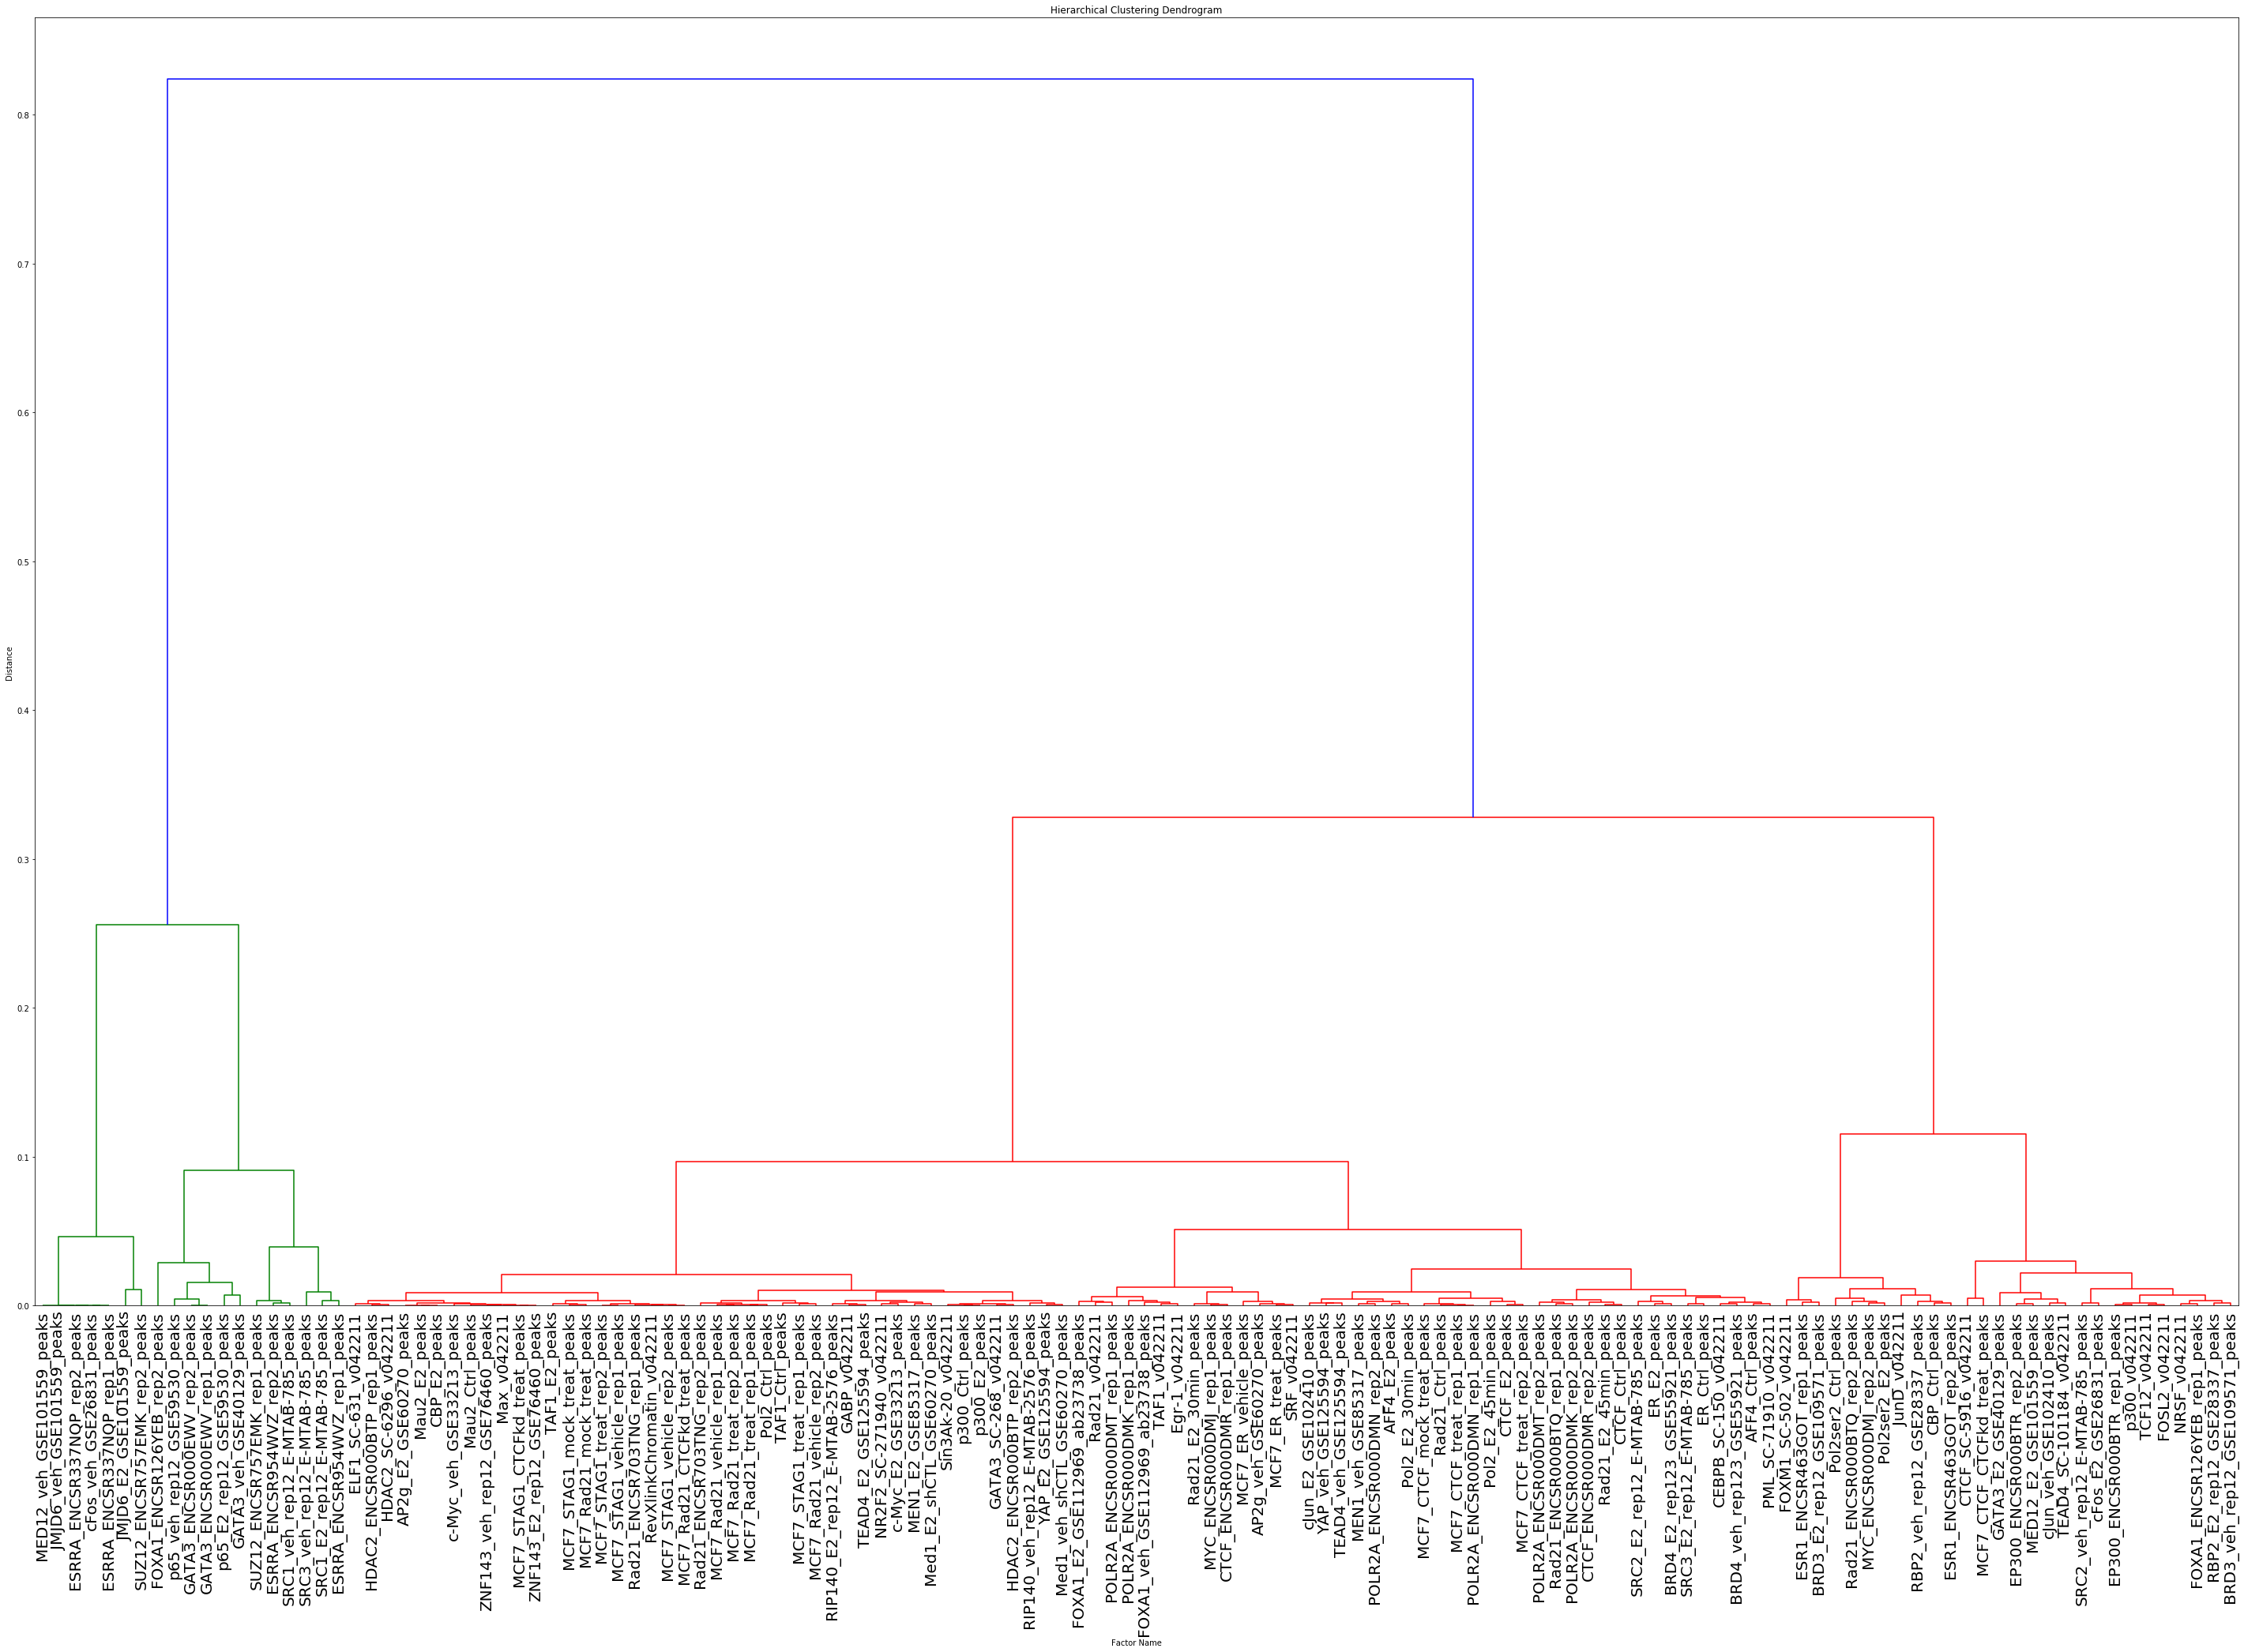

In [22]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

# Extract node embeddings from the trained embedding model
node_embeddings = embedding_model.predict(node_gen)

# Reshape the embeddings data to ensure it's two-dimensional
node_embeddings_reshaped = node_embeddings.squeeze()

# Perform hierarchical clustering using the linkage method
# Uncomment the following line to compute the linkage matrix if not already saved
#linked = linkage(node_embeddings_reshaped, 'ward')
# Save the linkage matrix for future use to avoid recomputation
#np.save('linked_matrix_boundary_minus_resolution10000.npy', linked)
# Load the precomputed linkage matrix
linked = np.load('linked_matrix_boundary_minus_resolution10000.npy')

# Prepare a list of factor names ensuring the order matches rows in node_embeddings_reshaped
factor_names = node_data.index

# Plot the dendrogram for the hierarchical clustering
plt.figure(figsize=(50, 30))  # Set the figure size for better visibility
dendrogram(linked, 
           orientation='top',  # Place the root at the top
           distance_sort='descending',  # Sort the distances in descending order
           labels=factor_names,  # Use factor names as labels for the dendrogram leaves
           show_leaf_counts=True)  # Show the number of items in each cluster
plt.title('Hierarchical Clustering Dendrogram')  # Title of the dendrogram
plt.xlabel('Factor Name')  # Label for the x-axis
plt.ylabel('Distance')  # Label for the y-axis
plt.xticks(rotation=90, fontsize=20)  # Rotate the x-axis labels for readability

# Display the plot
plt.show()



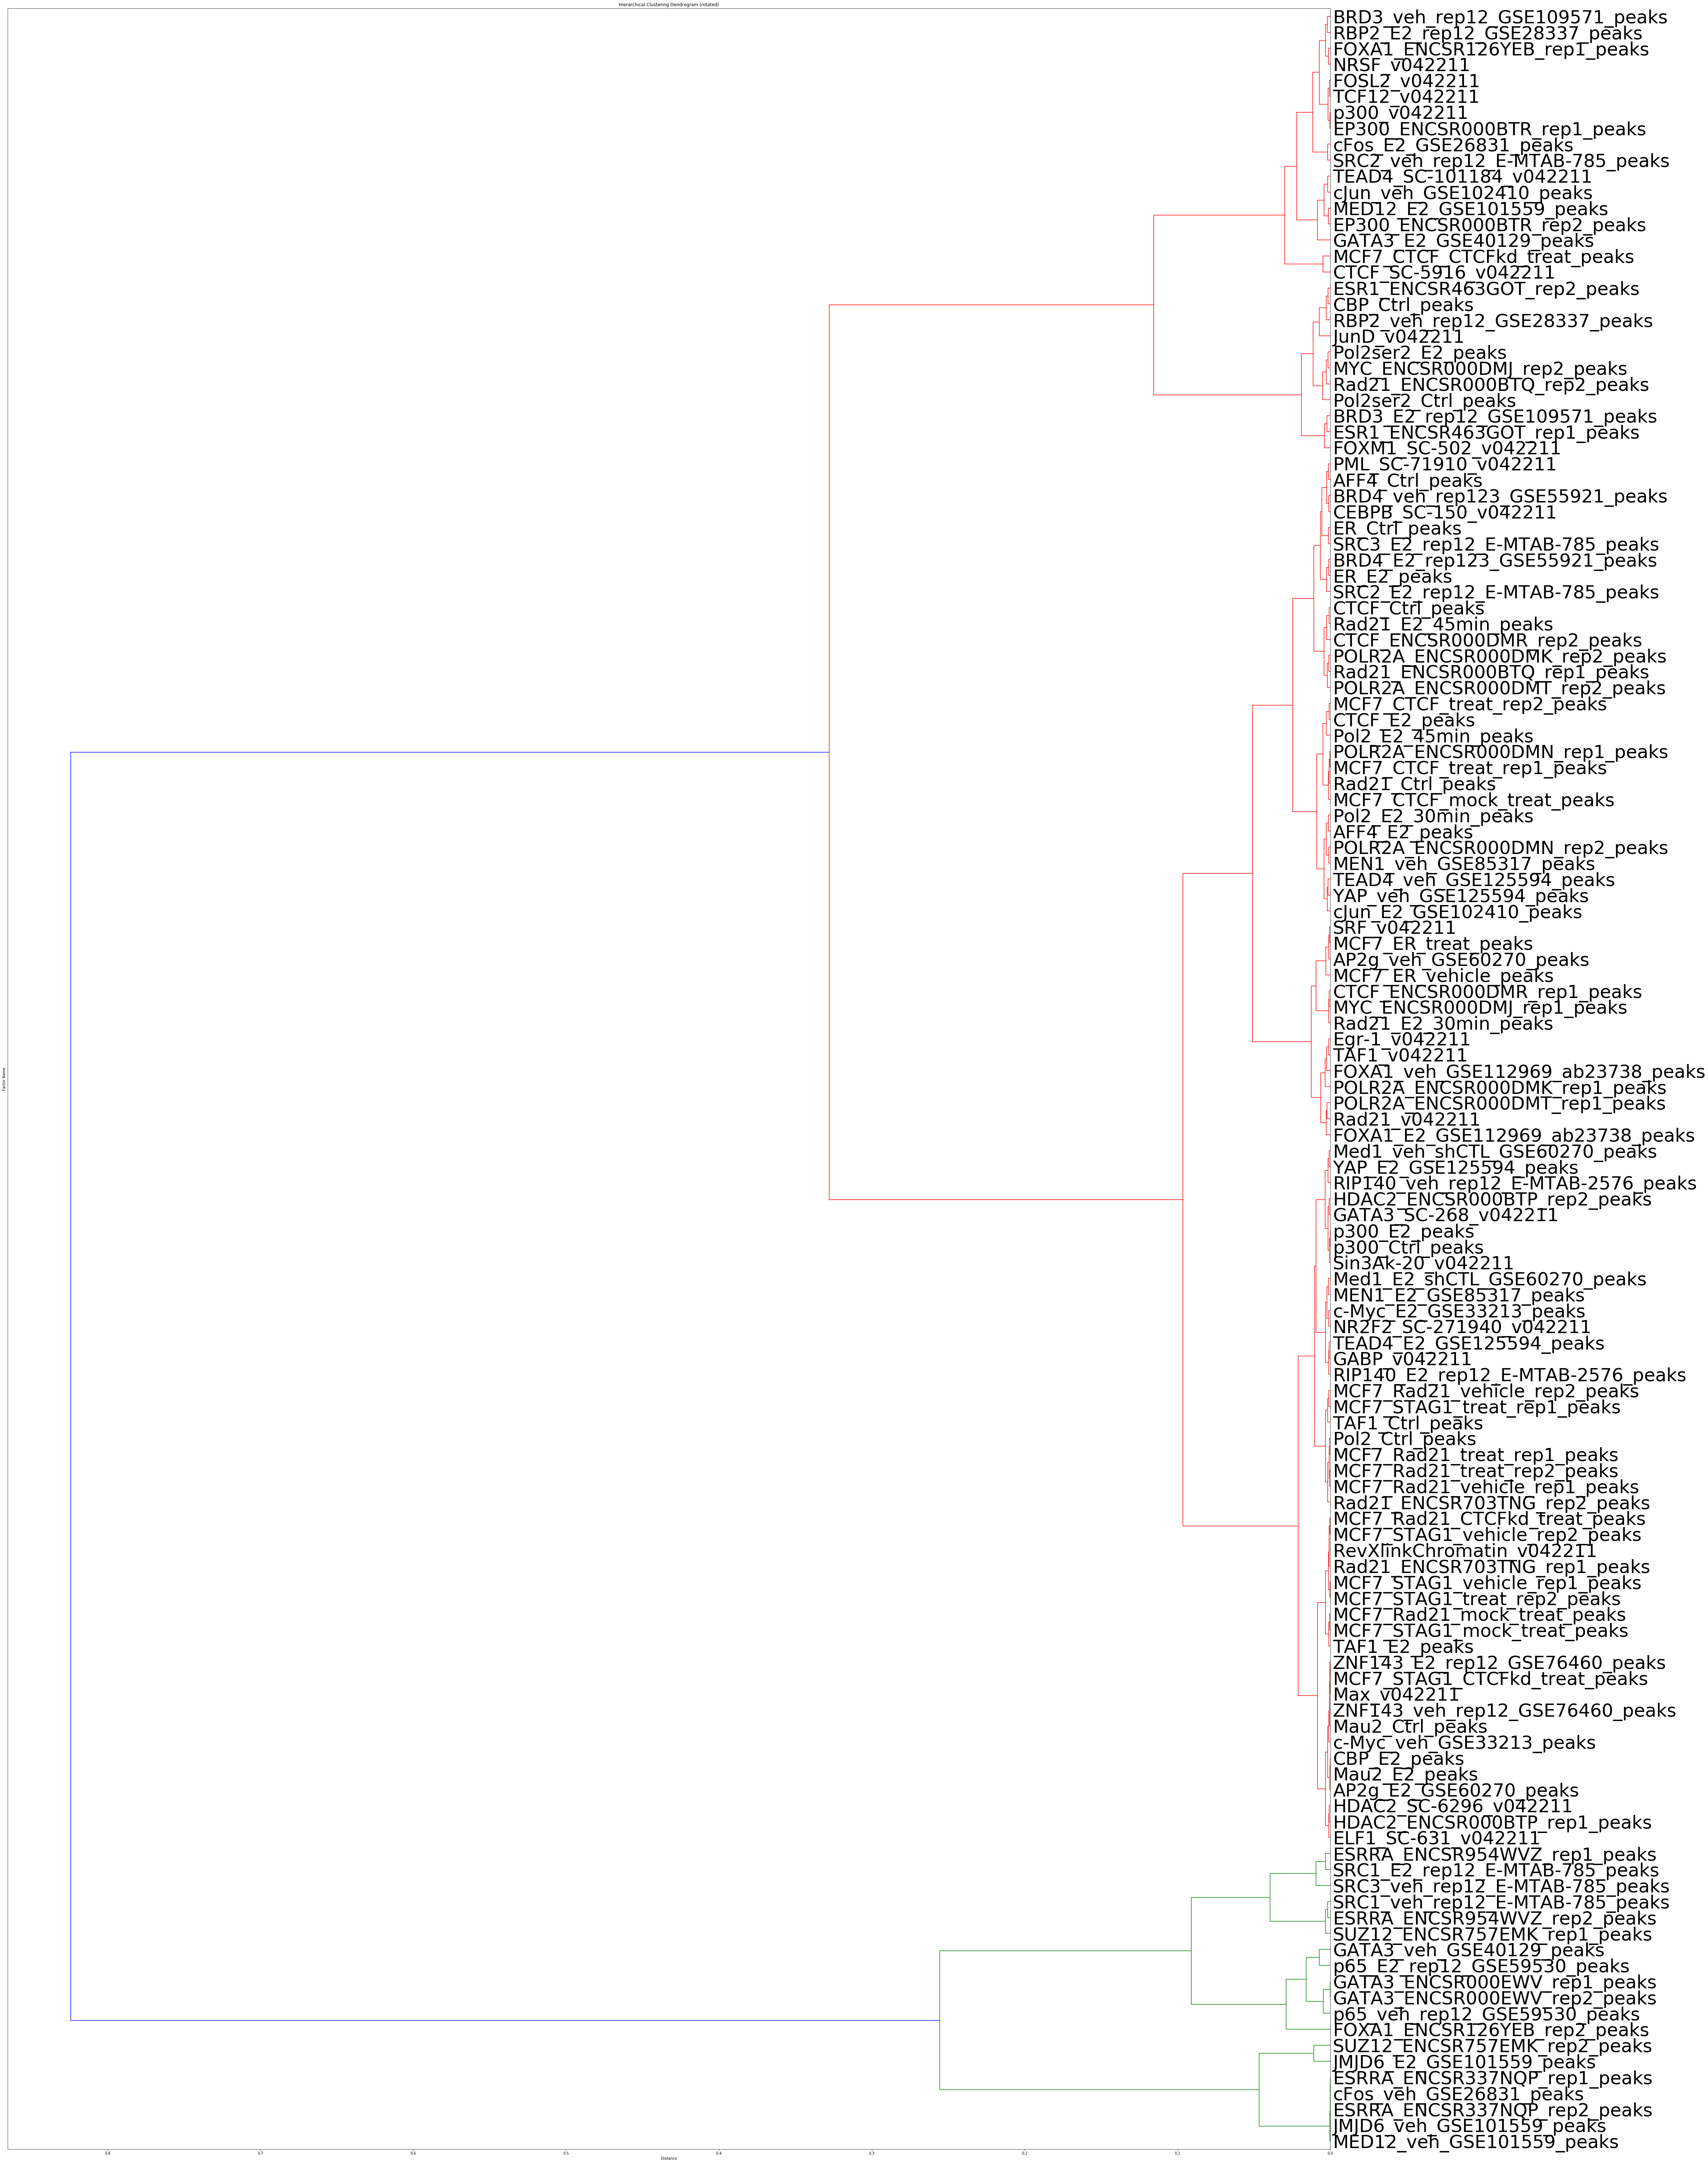

In [23]:
import numpy as np
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

# Load your linkage matrix
linked = np.load('linked_matrix_boundary_minus_resolution10000.npy')

# Replace with your actual factor names
factor_names = node_data.index

# Plotting the dendrogram rotated by 90 degrees to improve readability of factor names
plt.figure(figsize=(65, 108))  # Adjust the size as needed
dendrogram(linked,
           orientation='left',  # Rotate the dendrogram to display horizontally
           labels=factor_names,  # Use factor names as labels
           show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram (rotated)')
plt.xlabel('Distance')
plt.ylabel('Factor Name')
plt.xticks(fontsize=10)  # Adjust the font size as needed for distance ticks
plt.yticks(fontsize=50)  # Adjust the font size as needed for factor names
plt.show()


In [24]:
from sklearn.metrics import silhouette_score

# Extract cluster labels from the linkage matrix using fcluster
from scipy.cluster.hierarchy import fcluster
# fcluster is used to form flat clusters from the hierarchical clustering defined by the given linkage matrix.
# 't' is the threshold to apply when forming flat clusters, and 'criterion' specifies the criterion for forming these clusters.
cluster_labels = fcluster(linked, t=0.05, criterion='distance')

# Calculate the silhouette score to evaluate the quality of the clustering
# The silhouette score is a measure of how similar an object is to its own cluster compared to other clusters.
# The silhouette scores range from -1 to 1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.
silhouette_avg = silhouette_score(node_embeddings_reshaped, cluster_labels)
print("The average silhouette_score is :", silhouette_avg)



The average silhouette_score is : 0.37460327


In [25]:
from scipy.cluster.hierarchy import fcluster
import pandas as pd

# Assuming you already have the linkage matrix 'linked' and a list of factor names 'factor_names'
# Set a cutoff distance for clustering, which should be based on the dendrogram analysis
# For example, a larger distance value observed in the dendrogram could be chosen as the cutoff point, here assumed to be 0.4
cut_off_distance = 0.4

# Use fcluster to form flat clusters from the hierarchical clustering defined by 'linked', based on the specified cutoff distance
cluster_labels = fcluster(linked, cut_off_distance, criterion='distance')

# Map cluster labels to factor names into a dictionary
clusters = {}
for label, factor in zip(cluster_labels, factor_names):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(factor)

# Create a DataFrame to display the list of factors in each cluster
cluster_df = pd.DataFrame.from_dict(clusters, orient='index').transpose()

# Print the first few rows of the DataFrame
print(cluster_df)

# Optionally, save the DataFrame to a CSV file for further analysis or sharing
cluster_df.to_csv("cluster_factors_boundary_minus_resolution10000.csv", index=False)


                                      2                                1
0                          NRSF_v042211        MED12_veh_GSE101559_peaks
1          HDAC2_ENCSR000BTP_rep1_peaks     FOXA1_ENCSR126YEB_rep2_peaks
2                         Rad21_v042211     SUZ12_ENCSR757EMK_rep1_peaks
3                          GABP_v042211         JMJD6_E2_GSE101559_peaks
4               YAP_veh_GSE125594_peaks     SUZ12_ENCSR757EMK_rep2_peaks
5                        CBP_Ctrl_peaks          cFos_veh_GSE26831_peaks
6          RBP2_E2_rep12_GSE28337_peaks     ESRRA_ENCSR337NQP_rep1_peaks
7           ESR1_ENCSR463GOT_rep1_peaks     ESRRA_ENCSR954WVZ_rep2_peaks
8    RIP140_veh_rep12_E-MTAB-2576_peaks  SRC3_veh_rep12_E-MTAB-785_peaks
9                          TAF1_v042211  SRC1_veh_rep12_E-MTAB-785_peaks
10                      AFF4_Ctrl_peaks     p65_veh_rep12_GSE59530_peaks
11                  MCF7_ER_treat_peaks      p65_E2_rep12_GSE59530_peaks
12                        Mau2_E2_peaks   SRC1_E2_r

In [26]:
Negative_factors = cluster_df[1].dropna().tolist()

Negative_factors 

['MED12_veh_GSE101559_peaks',
 'FOXA1_ENCSR126YEB_rep2_peaks',
 'SUZ12_ENCSR757EMK_rep1_peaks',
 'JMJD6_E2_GSE101559_peaks',
 'SUZ12_ENCSR757EMK_rep2_peaks',
 'cFos_veh_GSE26831_peaks',
 'ESRRA_ENCSR337NQP_rep1_peaks',
 'ESRRA_ENCSR954WVZ_rep2_peaks',
 'SRC3_veh_rep12_E-MTAB-785_peaks',
 'SRC1_veh_rep12_E-MTAB-785_peaks',
 'p65_veh_rep12_GSE59530_peaks',
 'p65_E2_rep12_GSE59530_peaks',
 'SRC1_E2_rep12_E-MTAB-785_peaks',
 'GATA3_veh_GSE40129_peaks',
 'ESRRA_ENCSR337NQP_rep2_peaks',
 'GATA3_ENCSR000EWV_rep2_peaks',
 'ESRRA_ENCSR954WVZ_rep1_peaks',
 'GATA3_ENCSR000EWV_rep1_peaks',
 'JMJD6_veh_GSE101559_peaks']

In [27]:
# Prepare a DataFrame to store the average values for each cluster
cluster_averages = pd.DataFrame(columns=['Cluster', 'Avg_cosine_similarity_vector1', 'Avg_cosine_similarity_vector2', 'Avg_cosine_similarity_h1d'])

for cluster_id, factors in cluster_df.iteritems():
    # Select the rows corresponding to the current cluster's factors
    cluster_data = df_B[df_B['Factor'].isin(factors.dropna().tolist())]
    
    # Calculate the mean values for the cosine similarity vectors
    mean_values = cluster_data[['signal_vector1_cosine', 'signal_vector1_manhattan', 'signal_vector2_cosine', 'signal_vector2_manhattan', 'h1d_vector_cosine', 'h1d_vector_manhattan']].mean()
    
    # Append the results to the cluster_averages DataFrame
    cluster_averages = cluster_averages.append({
        'Cluster': cluster_id,
        'Avg_cosine_similarity_vector1': mean_values['signal_vector1_cosine'],
        'Avg_manhattan_vector1': mean_values['signal_vector1_manhattan'],
        'Avg_cosine_similarity_vector2': mean_values['signal_vector2_cosine'],
        'Avg_manhattan_vector2': mean_values['signal_vector2_manhattan'],
        'Avg_cosine_similarity_h1d': mean_values['h1d_vector_cosine'],
        'Avg_manhattan_h1d': mean_values['h1d_vector_manhattan']
    }, ignore_index=True)

# Output the results
print(cluster_averages)

cluster_averages.to_csv("cluster_averages_boundary_minus_resolution10000.csv", index=False)

   Cluster  Avg_cosine_similarity_vector1  Avg_cosine_similarity_vector2  \
0      2.0                       0.233602                       0.292949   
1      1.0                       0.052702                       0.063671   

   Avg_cosine_similarity_h1d  Avg_manhattan_h1d  Avg_manhattan_vector1  \
0                   0.166244           0.263404               0.297359   
1                   0.036677           0.014078               0.017812   

   Avg_manhattan_vector2  
0               0.314083  
1               0.018338  


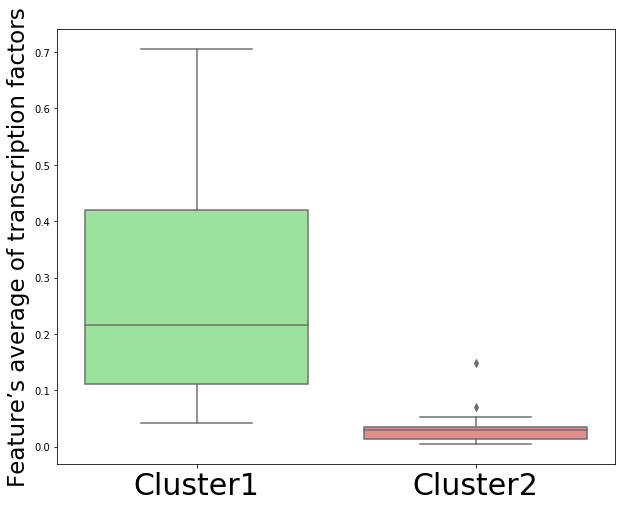

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Ensure pandas is imported

# Assuming sorted_filtered_factors1 and sorted_filtered_factors are pre-prepared DataFrames

# To create a box plot, first, we need to merge the two DataFrames into one and include a category label column
sorted_filtered_factors1['Cluster'] = 'Cluster1'  # Assign all rows in the first DataFrame to 'Cluster1'
sorted_filtered_factors['Cluster'] = 'Cluster2'   # Assign all rows in the second DataFrame to 'Cluster2'
# Concatenate the two DataFrames vertically while ignoring the original index with ignore_index=True
combined_data = pd.concat([sorted_filtered_factors1, sorted_filtered_factors], ignore_index=True)

# Plotting the box plot
plt.figure(figsize=(10, 8))  # Set the figure size for better visibility
# Create a box plot with 'Cluster' on the x-axis and 'Average' on the y-axis
sns.boxplot(x='Cluster', y='Average', data=combined_data,
            palette={'Cluster1': 'lightgreen', 'Cluster2': 'lightcoral'})  # Set colors for each cluster

# Setting font size and title
plt.xlabel('', fontsize=30)  # Leave x-label blank since 'Cluster1' and 'Cluster2' are already included as categories
plt.ylabel('Feature’s average of transcription factors', fontsize=23)  # Set y-axis label

# Adjust font size for x-axis labels
plt.xticks(fontsize=30)

# Display the plot
plt.show()



In [28]:
import pandas as pd

# Assuming df_B already exists and contains data for all factors
# The following line should be replaced with your actual data loading/definition code
# df_B = pd.read_csv('path_to_your_data.csv')  # In case your data is loaded from a CSV file

# Select columns that contain cosine similarity and Manhattan distance measurements
columns_of_interest = ['signal_vector1_cosine', 'signal_vector1_manhattan',
                       'signal_vector2_cosine', 'signal_vector2_manhattan', 
                       'h1d_vector_cosine', 'h1d_vector_manhattan']

# Calculate the average value across the selected columns for each factor
df_B['Average'] = df_B[columns_of_interest].mean(axis=1)

# Sort the factors by their average values in ascending order
sorted_factors = df_B.sort_values(by='Average')

# Output the result showing each factor and its average value
print(sorted_factors[['Factor', 'Average']])

# Save the sorted factors and their averages to a CSV file for further use or analysis
sorted_factors.to_csv("sorted_factors_averages_resolution10000.csv", index=False)



                                 Factor   Average
3             MED12_veh_GSE101559_peaks  0.004819
88         ESRRA_ENCSR337NQP_rep2_peaks  0.007112
57         ESRRA_ENCSR337NQP_rep1_peaks  0.007294
125           JMJD6_veh_GSE101559_peaks  0.007773
52              cFos_veh_GSE26831_peaks  0.012860
43             JMJD6_E2_GSE101559_peaks  0.014629
84       SRC1_E2_rep12_E-MTAB-785_peaks  0.025837
80         p65_veh_rep12_GSE59530_peaks  0.025941
64      SRC3_veh_rep12_E-MTAB-785_peaks  0.027700
83          p65_E2_rep12_GSE59530_peaks  0.029265
49         SUZ12_ENCSR757EMK_rep2_peaks  0.029493
119        GATA3_ENCSR000EWV_rep1_peaks  0.032156
94         GATA3_ENCSR000EWV_rep2_peaks  0.032156
113        ESRRA_ENCSR954WVZ_rep1_peaks  0.033539
73      SRC1_veh_rep12_E-MTAB-785_peaks  0.037719
50       BRD3_veh_rep12_GSE109571_peaks  0.041802
62         ESRRA_ENCSR954WVZ_rep2_peaks  0.042696
101            MED12_E2_GSE101559_peaks  0.045150
16        BRD3_E2_rep12_GSE109571_peaks  0.048892


/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [29]:
# Filter df_B to only include factors that are in the Negative_factors list
filtered_df_B = df_B[df_B['Factor'].isin(Negative_factors)]

# Calculate the average value across selected columns for each of these filtered factors
filtered_df_B['Average'] = filtered_df_B[columns_of_interest].mean(axis=1)

# Sort the filtered factors by their average values in ascending order
sorted_filtered_factors = filtered_df_B.sort_values(by='Average')

# Output the sorted list showing each factor and its calculated average value
print(sorted_filtered_factors[['Factor', 'Average']])

                              Factor   Average
3          MED12_veh_GSE101559_peaks  0.004819
88      ESRRA_ENCSR337NQP_rep2_peaks  0.007112
57      ESRRA_ENCSR337NQP_rep1_peaks  0.007294
125        JMJD6_veh_GSE101559_peaks  0.007773
52           cFos_veh_GSE26831_peaks  0.012860
43          JMJD6_E2_GSE101559_peaks  0.014629
84    SRC1_E2_rep12_E-MTAB-785_peaks  0.025837
80      p65_veh_rep12_GSE59530_peaks  0.025941
64   SRC3_veh_rep12_E-MTAB-785_peaks  0.027700
83       p65_E2_rep12_GSE59530_peaks  0.029265
49      SUZ12_ENCSR757EMK_rep2_peaks  0.029493
119     GATA3_ENCSR000EWV_rep1_peaks  0.032156
94      GATA3_ENCSR000EWV_rep2_peaks  0.032156
113     ESRRA_ENCSR954WVZ_rep1_peaks  0.033539
73   SRC1_veh_rep12_E-MTAB-785_peaks  0.037719
62      ESRRA_ENCSR954WVZ_rep2_peaks  0.042696
19      SUZ12_ENCSR757EMK_rep1_peaks  0.053373
87          GATA3_veh_GSE40129_peaks  0.071247
13      FOXA1_ENCSR126YEB_rep2_peaks  0.148106


/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [31]:
# Prepare a DataFrame to store the average values for each cluster
cluster_averages = pd.DataFrame(columns=['Cluster', 
                                         'Avg_cosine_similarity_vector1', 
                                         'Avg_manhattan_vector1',
                                         'Avg_cosine_similarity_vector2',
                                         'Avg_manhattan_vector2',
                                         'Avg_cosine_similarity_h1d',
                                         'Avg_manhattan_h1d',
                                         'Overall_Avg'])

for cluster_id, factors in cluster_df.iteritems():
    # Select the rows corresponding to the current cluster's factors
    cluster_data = df_B[df_B['Factor'].isin(factors.dropna().tolist())]
    
    # Calculate the mean values for the cosine similarity vectors
    mean_values = cluster_data[['signal_vector1_cosine', 
                                'signal_vector1_manhattan', 
                                'signal_vector2_cosine', 
                                'signal_vector2_manhattan', 
                                'h1d_vector_cosine', 
                                'h1d_vector_manhattan']].mean()
    
    # Calculate the overall average of the features for the cluster
    overall_avg = mean_values.mean()
    
    # Append the results to the cluster_averages DataFrame
    cluster_averages = cluster_averages.append({
        'Cluster': cluster_id,
        'Avg_cosine_similarity_vector1': mean_values['signal_vector1_cosine'],
        'Avg_manhattan_vector1': mean_values['signal_vector1_manhattan'],
        'Avg_cosine_similarity_vector2': mean_values['signal_vector2_cosine'],
        'Avg_manhattan_vector2': mean_values['signal_vector2_manhattan'],
        'Avg_cosine_similarity_h1d': mean_values['h1d_vector_cosine'],
        'Avg_manhattan_h1d': mean_values['h1d_vector_manhattan'],
        'Overall_Avg': overall_avg
    }, ignore_index=True)

# Output the results
print(cluster_averages)

# Save the DataFrame to a CSV file
cluster_averages.to_csv("cluster_averages_boundary_minus_resolution10000.csv", index=False)


   Cluster  Avg_cosine_similarity_vector1  Avg_manhattan_vector1  \
0      2.0                       0.233602               0.297359   
1      1.0                       0.052702               0.017812   

   Avg_cosine_similarity_vector2  Avg_manhattan_vector2  \
0                       0.292949               0.314083   
1                       0.063671               0.018338   

   Avg_cosine_similarity_h1d  Avg_manhattan_h1d  Overall_Avg  
0                   0.166244           0.263404     0.261273  
1                   0.036677           0.014078     0.033880  


# Negative factor region detection

In [40]:
import numpy as np

results = {}  # Dictionary to store the results

# Loop through each factor in Negative_factors
for factor in Negative_factors:
    if factor in tf_files_simplified:
        # Find the index of the factor in the simplified list of transcription factor files
        factor_index = tf_files_simplified.index(factor)
        # Extract the corresponding column from the overlap matrix
        factor_column = overlap_matrix[:, factor_index]
        # Find indices where the factor column has non-zero values
        non_zero_indices = np.where(factor_column > 0)[0]
        # Calculate the average of selected values from response_vector1 and response_vector2
        selected_values = (response_vector1[non_zero_indices] + response_vector2[non_zero_indices]) / 2
        
        # Proceed if there are any non-zero selected values
        if len(selected_values) > 0:
            # Use percentile as a threshold for filtering
            # Calculate the 30th percentile as the threshold, implying values below this are considered
            threshold = np.percentile(selected_values, 30)

            # Identify indices where values are below the threshold
            above_threshold = non_zero_indices[selected_values < threshold]

            # Fetch the specific locations corresponding to these indices from filtered_HMR
            regions_above = [filtered_HMR[i] for i in above_threshold]

            # Store the results for this factor
            results[factor] = {
                'threshold': threshold,
                'above_threshold': regions_above
            }

            # Print the factor and the count of regions above the threshold
            print(f"Factor: {factor}")
            print(f"Regions above threshold: {len(regions_above)}")
            print()

# To view specific results, you can directly access the results dictionary
# For example, to view results for a specific factor:
for factor, data in results.items():
    print(f"Results for {factor}:")
    print(f"Regions above threshold: {data['above_threshold']}")
    print()



Factor: MED12_veh_GSE101559_peaks
Regions above threshold: 1

Factor: FOXA1_ENCSR126YEB_rep2_peaks
Regions above threshold: 333

Factor: SUZ12_ENCSR757EMK_rep1_peaks
Regions above threshold: 58

Factor: JMJD6_E2_GSE101559_peaks
Regions above threshold: 5

Factor: SUZ12_ENCSR757EMK_rep2_peaks
Regions above threshold: 22

Factor: cFos_veh_GSE26831_peaks
Regions above threshold: 3

Factor: ESRRA_ENCSR337NQP_rep1_peaks
Regions above threshold: 2

Factor: ESRRA_ENCSR954WVZ_rep2_peaks
Regions above threshold: 44

Factor: SRC3_veh_rep12_E-MTAB-785_peaks
Regions above threshold: 12

Factor: SRC1_veh_rep12_E-MTAB-785_peaks
Regions above threshold: 21

Factor: p65_veh_rep12_GSE59530_peaks
Regions above threshold: 16

Factor: p65_E2_rep12_GSE59530_peaks
Regions above threshold: 20

Factor: SRC1_E2_rep12_E-MTAB-785_peaks
Regions above threshold: 15

Factor: GATA3_veh_GSE40129_peaks
Regions above threshold: 111

Factor: ESRRA_ENCSR337NQP_rep2_peaks
Regions above threshold: 2

Factor: GATA3_ENCSR000

# Postive factor region detection

In [41]:
Positive_factors = cluster_df[2].dropna().tolist()

Positive_factors 

['NRSF_v042211',
 'HDAC2_ENCSR000BTP_rep1_peaks',
 'Rad21_v042211',
 'GABP_v042211',
 'YAP_veh_GSE125594_peaks',
 'CBP_Ctrl_peaks',
 'RBP2_E2_rep12_GSE28337_peaks',
 'ESR1_ENCSR463GOT_rep1_peaks',
 'RIP140_veh_rep12_E-MTAB-2576_peaks',
 'TAF1_v042211',
 'AFF4_Ctrl_peaks',
 'MCF7_ER_treat_peaks',
 'Mau2_E2_peaks',
 'BRD3_E2_rep12_GSE109571_peaks',
 'Pol2_E2_45min_peaks',
 'c-Myc_veh_GSE33213_peaks',
 'MCF7_STAG1_CTCFkd_treat_peaks',
 'MCF7_STAG1_treat_rep1_peaks',
 'TCF12_v042211',
 'MCF7_Rad21_treat_rep1_peaks',
 'MCF7_ER_vehicle_peaks',
 'EP300_ENCSR000BTR_rep2_peaks',
 'AP2g_E2_GSE60270_peaks',
 'cJun_veh_GSE102410_peaks',
 'RBP2_veh_rep12_GSE28337_peaks',
 'MEN1_veh_GSE85317_peaks',
 'CEBPB_SC-150_v042211',
 'ER_E2_peaks',
 'CTCF_E2_peaks',
 'BRD4_E2_rep123_GSE55921_peaks',
 'EP300_ENCSR000BTR_rep1_peaks',
 'BRD4_veh_rep123_GSE55921_peaks',
 'PML_SC-71910_v042211',
 'MCF7_Rad21_vehicle_rep1_peaks',
 'MCF7_CTCF_treat_rep1_peaks',
 'CTCF_ENCSR000DMR_rep2_peaks',
 'Rad21_ENCSR703TNG_re

In [42]:
# Filter df_B to include only factors present in Positive_factors
filtered_df_B = df_B[df_B['Factor'].isin(Positive_factors)]

# Calculate the average value across selected columns for each of these filtered factors
filtered_df_B['Average'] = filtered_df_B[columns_of_interest].mean(axis=1)

# Sort the filtered factors by their average values in ascending order
sorted_filtered_factors1 = filtered_df_B.sort_values(by='Average')

# Output the sorted list showing each factor and its calculated average value
print(sorted_filtered_factors1[['Factor', 'Average']])


                                 Factor   Average
50       BRD3_veh_rep12_GSE109571_peaks  0.041802
101            MED12_E2_GSE101559_peaks  0.045150
16        BRD3_E2_rep12_GSE109571_peaks  0.048892
34         EP300_ENCSR000BTR_rep1_peaks  0.051343
6                        CBP_Ctrl_peaks  0.055044
105             TEAD4_SC-101184_v042211  0.056979
7          RBP2_E2_rep12_GSE28337_peaks  0.057877
25         EP300_ENCSR000BTR_rep2_peaks  0.061024
98      SRC2_veh_rep12_E-MTAB-785_peaks  0.065939
135             AP2g_veh_GSE60270_peaks  0.066196
22                        TCF12_v042211  0.066318
11                         TAF1_v042211  0.068421
99               cFos_E2_GSE26831_peaks  0.068524
72                 FOXM1_SC-502_v042211  0.073157
66                         p300_v042211  0.074265
114                         SRF_v042211  0.077218
74                        Egr-1_v042211  0.077302
0                          NRSF_v042211  0.080391
28        RBP2_veh_rep12_GSE28337_peaks  0.080410


/home/zhou/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [47]:
import numpy as np

results = {}  # Dictionary to store the results

# Iterate through each factor in the specified cluster (cluster_4_factors in this case)
for factor in cluster_4_factors:
    # Check if the factor is present in the simplified list of transcription factor files
    if factor in tf_files_simplified:
        # Find the index of the factor in the list
        factor_index = tf_files_simplified.index(factor)
        # Extract the corresponding column from the overlap matrix
        factor_column = overlap_matrix[:, factor_index]
        # Find indices where the factor column has non-zero values
        non_zero_indices = np.where(factor_column > 0)[0]
        # Calculate the average of values from response_vector1 and response_vector2 for these indices
        selected_values = (response_vector1[non_zero_indices] + response_vector2[non_zero_indices]) / 2
        
        # Proceed if there are non-zero selected values
        if len(selected_values) > 0:
            # Set a threshold based on the 30th percentile of the selected values
            threshold = np.percentile(selected_values, 30)

            # Identify indices where selected values are below the threshold
            above_threshold = non_zero_indices[selected_values < threshold]

            # Fetch the specific regions corresponding to these indices from filtered_HMR
            regions_above = [filtered_HMR[i] for i in above_threshold]

            # Store the results for this factor, including the threshold and regions above it
            results[factor] = {
                'threshold': threshold,
                'above_threshold': regions_above
            }

            # Print the factor and the count of regions above the threshold
            print(f"Factor: {factor}")
            print(f"Regions above threshold: {len(regions_above)}")
            print()

# To view specific results, you can directly access the results dictionary
# For instance, to view results for a particular factor:
for factor, data in results.items():
    print(f"Results for {factor}:")
    print(f"Regions above threshold: {data['above_threshold']}")
    print()

Factor: NRSF_v042211
Regions above threshold: 128

Factor: HDAC2_ENCSR000BTP_rep1_peaks
Regions above threshold: 293

Factor: Rad21_v042211
Regions above threshold: 1164

Factor: GABP_v042211
Regions above threshold: 184

Factor: YAP_veh_GSE125594_peaks
Regions above threshold: 215

Factor: CBP_Ctrl_peaks
Regions above threshold: 58

Factor: RBP2_E2_rep12_GSE28337_peaks
Regions above threshold: 65

Factor: ESR1_ENCSR463GOT_rep1_peaks
Regions above threshold: 190

Factor: RIP140_veh_rep12_E-MTAB-2576_peaks
Regions above threshold: 408

Factor: TAF1_v042211
Regions above threshold: 87

Factor: AFF4_Ctrl_peaks
Regions above threshold: 141

Factor: MCF7_ER_treat_peaks
Regions above threshold: 636

Factor: Mau2_E2_peaks
Regions above threshold: 493

Factor: BRD3_E2_rep12_GSE109571_peaks
Regions above threshold: 54

Factor: Pol2_E2_45min_peaks
Regions above threshold: 672

Factor: c-Myc_veh_GSE33213_peaks
Regions above threshold: 1469

Factor: MCF7_STAG1_CTCFkd_treat_peaks
Regions above thre

# Region detection for spesific factor

In [48]:
import numpy as np

def generate_results_for_factor(factor_name):
    """
    Generate and store results for a specified factor by identifying regions 
    where the average value from two response vectors is below a certain percentile threshold.
    
    Parameters:
    - factor_name: The name of the factor to analyze.
    
    Returns:
    - A dictionary containing the threshold used and the regions above this threshold.
    - Returns None if the factor is not found in the provided lists.
    """
    results = {}  # Dictionary to store the results

    # Check if the factor is in both the cluster list and the simplified file list
    if factor_name in cluster_4_factors and factor_name in tf_files_simplified:
        # Find the index of the factor
        factor_index = tf_files_simplified.index(factor_name)
        # Extract the corresponding column from the overlap matrix
        factor_column = overlap_matrix[:, factor_index]
        # Find non-zero indices in the column
        non_zero_indices = np.where(factor_column > 0)[0]
        # Calculate the average of values from two response vectors
        selected_values = (response_vector1[non_zero_indices] + response_vector2[non_zero_indices]) / 2

        # Proceed if there are non-zero selected values
        if len(selected_values) > 0:
            # Determine the threshold using percentile
            threshold = np.percentile(selected_values, 30)
            # Identify indices where values fall below the threshold
            above_threshold = non_zero_indices[selected_values < threshold]
            # Fetch the specific regions corresponding to these indices
            regions_above = [filtered_HMR[i] for i in above_threshold]

            # Store the results for the factor
            results[factor_name] = {
                'threshold': threshold,
                'above_threshold': regions_above
            }

            # Print the factor name and the count of regions above the threshold
            print(f"Factor: {factor_name}")
            print(f"Regions above threshold: {len(regions_above)}")
            print()

            return results
    else:
        # Print an error message if the factor is not found
        print("Error: The specified factor is not found in the cluster or file list.")
        return None

# Example usage of the function:
factor_to_check = "MED12_E2_GSE101559_peaks"
result_for_factor = generate_results_for_factor(factor_to_check)
if result_for_factor:
    # Print the results for the specified factor
    print(result_for_factor)



Factor: MED12_E2_GSE101559_peaks
Regions above threshold: 39

{'MED12_E2_GSE101559_peaks': {'threshold': 0.3114162895211411, 'above_threshold': [('chr1', 111630000, 111631000), ('chr1', 153996000, 153997000), ('chr1', 204381000, 204382000), ('chr10', 79239000, 79240000), ('chr12', 52371000, 52372000), ('chr12', 103524000, 103525000), ('chr13', 27379000, 27380000), ('chr14', 63809000, 63810000), ('chr14', 70104000, 70105000), ('chr17', 41506000, 41507000), ('chr2', 20113000, 20114000), ('chr2', 20475000, 20476000), ('chr2', 64906000, 64907000), ('chr2', 105566000, 105567000), ('chr20', 829000, 830000), ('chr21', 15587000, 15588000), ('chr3', 4714000, 4715000), ('chr3', 4717000, 4718000), ('chr3', 41205000, 41206000), ('chr3', 156813000, 156814000), ('chr3', 186772000, 186773000), ('chr3', 192818000, 192819000), ('chr3', 193787000, 193788000), ('chr3', 194150000, 194151000), ('chr5', 67237000, 67238000), ('chr5', 91939000, 91940000), ('chr5', 133286000, 133287000), ('chr5', 149810000, 14